<a href="https://colab.research.google.com/github/IOlivaresPalma/Multimedia-Trabajos/blob/main/Olivares_Ivan_197615435_Proyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install sounddevice --quiet
!pip install pydub --quiet
!pip install ipython --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

filename = 'H-H1_GWOSC_4KHZ_R1-1126259447-32.txt'

datos = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=float)
len(datos)

131072

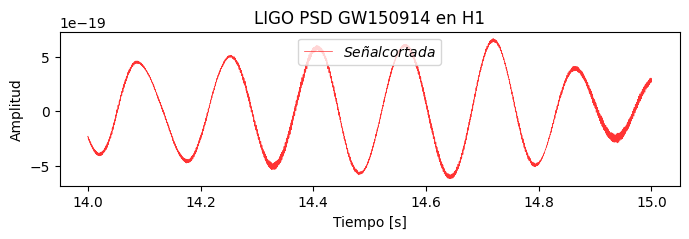

In [4]:
fs = 4000  # frecuencia de sampleo

# Se define el tiempo en base al sampleo
time = np.arange(datos.size)
max_time = datos.size / fs

lim_inf = 14 # límite inferior de la ventana de tiempo
lim_sup = 15  # límite superior de la ventana de tiempo

muestra_inferior = lim_inf * fs  # Muestra de tiempo correspondiente al límite inferior
muestra_superior = lim_sup * fs  # Muestra de tiempo correspondiente al límite superior

# Se definen los pasos de tiempo dentro de la ventana especificada
time_steps = np.linspace(lim_inf, lim_sup, datos[muestra_inferior:muestra_superior].size)

# Gráfica
plt.figure(figsize=(8, 2))
plt.plot(time_steps, datos[muestra_inferior:muestra_superior], 'red', label=r'$Señal cortada$', alpha=0.8, linewidth=0.5)

# Etiquetas y título
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.legend(loc='upper center')
plt.title('LIGO PSD ' + "GW150914" + ' en H1')
plt.show()


In [5]:
from scipy.io.wavfile import write
import IPython.display as ipd
from pydub import AudioSegment


dataSample=datos[muestra_inferior:muestra_superior] #ventana de tiempo seleccionada

m = np.max(np.abs(dataSample))
sigf32 = (dataSample/m).astype(np.float32) #normalizar datos

write("raw.wav", fs, sigf32) #saving
ipd.Audio('raw.wav') #playing

In [ ]:
len(dataSample)

4000

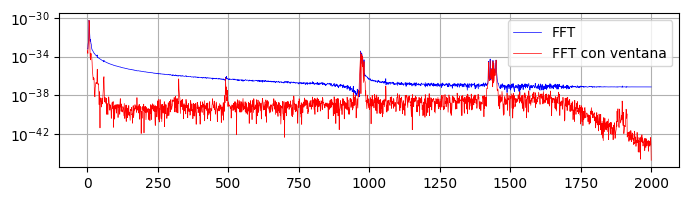

In [6]:
from scipy.fft import fft, fftfreq
from scipy.signal.windows import tukey

# Puntos de sampleo
N = dataSample.size

# Espaciado de muestra
T = 1.0 / fs
x = np.linspace(0.0, N*T, N, endpoint=False)

# FFT de la señal sin ventana
yf = fft(dataSample)

# Definición de la ventana Tukey
w = tukey(N, alpha=1./4)  # alpha=1./4 se usa en documentos

# Aplicación de la ventana y FFT
ywf = fft(dataSample * w)

# Frecuencias correspondientes a las muestras FFT
xf = fftfreq(N, T)

# Densidad de potencia
pdyf = np.abs(yf[1:N//2])**2  # sin ventana
pdywf = np.abs(ywf[1:N//2])**2  # con ventana

# Gráfica en escala logarítmica
plt.figure(figsize=(8,2))
plt.semilogy(xf[1:N//2], pdyf, '-b', linewidth=0.5)  # FFT sin ventana
plt.semilogy(xf[1:N//2], pdywf, '-r', linewidth=0.5)  # FFT con ventana
plt.legend(['FFT', 'FFT con ventana'])
plt.grid()
plt.show()


# Función de filtro pasa banda

Sugieren en el paper usar un filtro butterworth para una banda específica.

In [7]:
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, ifft

def bandpass(strain, fband, fs):
    """Filtrado pasa banda de la señal utilizando un filtro Butterworth.

    Args:
        strain (ndarray): datos de la señal a filtrar
        fband (ndarray): valores del filtro pasa banda (frecuencia baja y alta)
        fs (float): tasa de muestreo de los datos

    Returns:
        ndarray: array de datos de la señal filtrada pasa banda
    """
    # Diseño del filtro Butterworth
    bb, ab = butter(8, [fband[0]*2, fband[1]*2], btype='band', fs=fs)

    # Normalización para mantener la energía constante después del filtrado
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

    # Aplicación del filtro al dato de la señal
    strain_bp = filtfilt(bb, ab, strain) / normalization
    return strain_bp



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_bandpass(data, f_baja, f_alta, fs, order=5):
    """
    Aplica un filtro pasa banda Butterworth a una señal.

    Parameters:
    data (array): La señal de entrada a la cual se aplicará el filtro.
    f_baja (float): Frecuencia de corte inferior del filtro (en Hz).
    f_alta (float): Frecuencia de corte superior del filtro (en Hz).
    fs (float): Frecuencia de muestreo de la señal de entrada (en Hz).
    order (int): Orden del filtro Butterworth (por defecto es 5).

    Returns:
    array: La señal filtrada.
    """
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    low = f_baja / nyq  # Frecuencia de corte inferior normalizada
    high = f_alta / nyq  # Frecuencia de corte superior normalizada

    # Factor de normalización para compensar la amplitud del filtro
    norm = np.sqrt((-f_baja + f_alta) / nyq)

    # Cálculo de los coeficientes del filtro Butterworth
    b, a = butter(order, [low, high], btype='band')

    # Aplicación del filtro a la señal de entrada y normalización
    y = filtfilt(b, a, data) / norm

    return y



# Proceso completo de whitening y filtrado

Aquí está el resumen del proceso anterior.

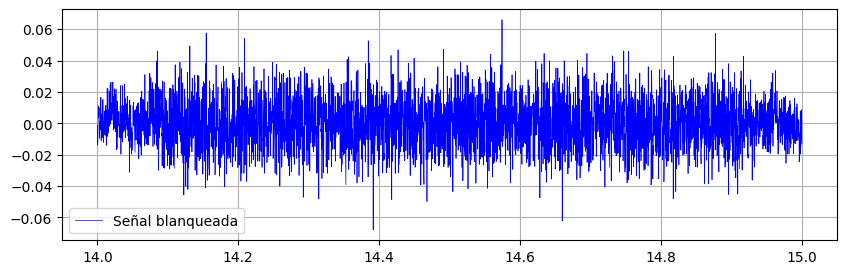

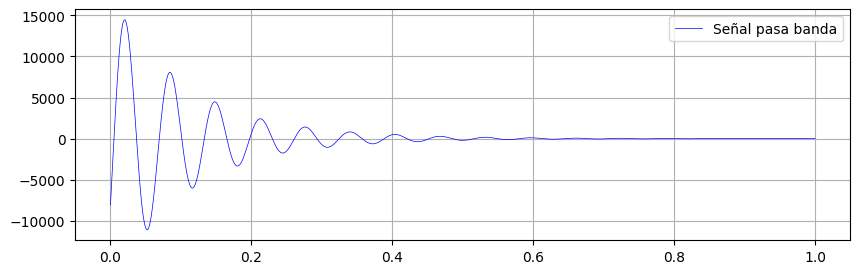

In [9]:
from scipy.signal import  butter, sosfilt, filtfilt
from scipy.fftpack import fft, ifft
import math

import math

def next_power_of_2(x):
    """
    Calcula la siguiente potencia de 2 para un número dado.

    Parameters:
    x (int): Número para calcular la siguiente potencia de 2.

    Returns:
    int: Siguiente potencia de 2 para el número dado.
    """
    if x <= 1:
        return 1
    else:
        return 2 ** math.ceil(math.log2(x))


# Definición de la banda para el filtro pasa banda
band = [20, 150]

nfft = next_power_of_2(N)  # Calcula el tamaño de la FFT, siguiente potencia de 2
spec = fft(dataSample*w, nfft)  # Transformada de Fourier

# Espectro de potencia
spec_ampl = np.sqrt(abs(np.multiply(spec, np.conjugate(spec))))

spec /= spec_ampl  # Normalización del espectro

# Transformada inversa de Fourier para obtener la señal blanqueada
ret_whitened = np.real(ifft(spec, nfft)[:N])

# Señal filtrada pasa banda
#sos = bandpass(ret_whitened, band, fs)  # Todas estas variables ya están definidas anteriormente
sos = butter_bandpass(ret_whitened,band[0],band[1],fs,6)

# Gráfica de la señal blanqueada sin filtro
plt.figure(figsize=(10, 3))
plt.plot(time_steps[:N], ret_whitened, '-b', linewidth=0.5)
plt.legend(['Señal blanqueada'])
plt.grid()
plt.show()

# Gráfica de la señal filtrada
plt.figure(figsize=(10, 3))
plt.plot(x, sos, '-b', linewidth=0.5)
plt.legend(['Señal pasa banda'])
plt.grid()
plt.show()

# Generación de audio
m = np.max(np.abs(sos))
sigf32 = (sos/m).astype(np.float32)
write("whitened2.wav", fs, sigf32)  # Guarda la señal como archivo de audio
ipd.Audio('whitened2.wav')  # Reproduce el archivo de audio



## Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Debe elegirse una frecuencia correcta que no induzca ruido en la señal.


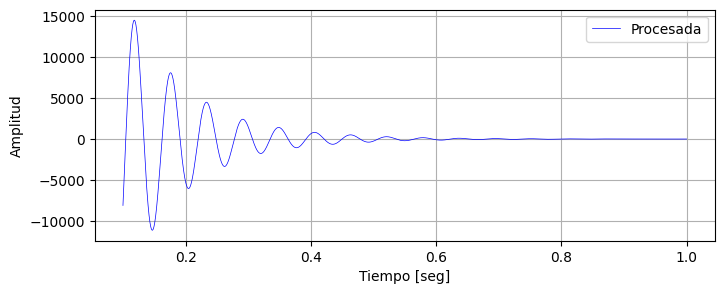

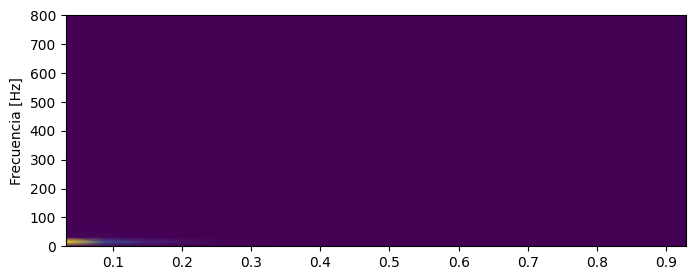

In [10]:
FS = 4000  # Frecuencia de muestreo

# Re-muestreo de la señal procesada
resampledSOS = signal.resample(sos, FS)  # Toma la señal procesada y la re-muestrea
section = resampledSOS#[muestra_inferior:muestra_superior]  # Selecciona una sección de la señal re-muestreada
"""
Busco una forma de poder definir más en el tiempo la señal a partir de las muestras
Modificar los divisores para cambiar la ventana de observación
"""

# Definición de nuevos límites de muestra para la sección
high_sample = int(FS / 1)
low_sample = int(FS / 10)

# Nuevo paso de tiempo
time_steps2 = np.linspace(low_sample / FS, high_sample / FS, section.size)

N = resampledSOS.size

# Gráfica de la sección procesada
plt.figure(figsize=(8, 3))
plt.plot(time_steps2, section, '-b', linewidth=0.5)
plt.legend(['Procesada'])
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [seg]')
plt.grid()
plt.show()

# Espectrograma de la sección
f, t, Sxx = signal.spectrogram(section, FS)

plt.figure(figsize=(8, 3))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
#plt.xlabel('Tiempo [seg]')
plt.ylim([0, 800])
plt.show()

# Generación de audio
m = np.max(np.abs(resampledSOS))
sigf32 = (section / m).astype(np.float32)
write("resampled.wav", fs, sigf32)  # Guarda la señal como archivo de audio
ipd.Audio('resampled.wav')  # Reproduce el archivo de audio
